<a href="https://colab.research.google.com/github/oliverfoster27/Practical-Machine-Learning/blob/master/Week%207/C7_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.layers import Dropout


import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from keras.optimizers import Adam

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data('/tmp/mnist.npz')
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)
X_train.shape, X_test.shape, y_train, y_test

((60000, 784),
 (10000, 784),
 array([5, 0, 4, ..., 5, 6, 8], dtype=uint8),
 array([7, 2, 1, ..., 4, 5, 6], dtype=uint8))

In [0]:
X_train = X_train / 255
X_test = X_test / 255

# Exercise
Make a dense neural network with 95%+ accuracy on Mnist that has the smallest number of neurons possible by experimenting with Dropout, and Batch Norm

### Strategy:
- Decide on a basic layer architecutre (one hidden dense layer with dropout and batch normalization)
- Iterate starting with 10 neurons to 100 on the hidden layer and find the optimal learning rate & p value for dropout
- If early stopping happens during training it indicates that the network may not be powerful enough. At this point increase the size of the dense layer
- When validation accuracy reaches 95% return that network's architecture

In [0]:
from keras.models import Sequential

# Grids to iterate through
learning_grid = [10e-6, 10e-5, 10e-4]
input_dense_grid = np.linspace(10, 100, 19).astype(int)
p_grid = [0.2, 0.4, 0.6]

def find_minimal_network(features, output, val_thresh=0.95):

  data = []

  for input_dense in input_dense_grid:
    
    stopped_early = False
    
    for learning_rate in learning_grid:
      
      if stopped_early:
        break
      
      for p in p_grid:

        K.clear_session()

        model = Sequential()

        # Baseline architecture
        model.add(Dense(input_dense, activation='relu', input_shape=(784,)))
        model.add(Dropout(p))
        model.add(BatchNormalization())
        model.add(Dense(10, activation='softmax'))

        callback_list = [EarlyStopping(monitor='val_acc', mode='max',
                                       verbose=0, patience=5)]

        optimizer = Adam(lr=learning_rate)
        model.compile(optimizer=optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

        print("\nNumber of Dense Nodes: {}".format(input_dense))
        print("Learning Rate: {}".format(learning_rate))
        print("Dropout P: {}".format(p))

        h = model.fit(features, output, epochs=100, validation_split=0.3,
                     callbacks=callback_list, verbose=0)

        # If we stop early our learning rate doesn't need to increase
        # so once we're done iterating through p increase the layer size
        stopping_interval = callback_list[0].stopped_epoch
        if stopping_interval > 0:
          stopped_early = True

        print("Early Stopping: {}".format(stopping_interval))
        print("Trained Validation Accuracy: {}".format(h.history['val_acc'][-1]))

        if h.history['val_acc'][-1] >= val_thresh:
          res={
            'Input Dense Layer Size': input_dense,
            'Learning Rate': learning_rate,
            'Dropout Proportion': p,
            'Validation Accuracy': h.history['acc'][-1]
          }
          # If we've satisfied 95% accuracy leave the learning rate grid
          return res

In [5]:
optimal_network = find_minimal_network(X_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Number of Dense Nodes: 10
Learning Rate: 1e-05
Dropout P: 0.2
Instructions for updating:
Use tf.cast instead.
Early Stopping: 0
Trained Validation Accuracy: 0.8922777777777777

Number of Dense Nodes: 10
Learning Rate: 1e-05
Dropout P: 0.4
Early Stopping: 0
Trained Validation Accuracy: 0.8823888888888889

Number of Dense Nodes: 10
Learning Rate: 1e-05
Dropout P: 0.6
Early Stopping: 0
Trained Validation Accuracy: 0.8424444444444444

Number of Dense Nodes: 10
Learning Rate: 0.0001
Dropout P: 0.2
Early Stopping: 30
Trained Validation Accuracy: 0.9103888888888889

Number of Dense Nodes: 10
Learning Rate: 0.0001
Dropout P: 0.4
Early Stopping: 30
Trained Validation Accuracy: 0.8892222222222222

Number of Dense Nodes: 10
Learning Rate: 0.0001
Dropout P: 0.6
Early Stopping: 31
Trained Validation Accuracy: 0.87

### Train network on minimum architecture

In [25]:
from keras.models import Sequential

input_dense = optimal_network['Input Dense Layer Size']
learning_rate = optimal_network['Learning Rate']
p = optimal_network['Dropout Proportion']

print("\nNumber of Dense Nodes: {}".format(input_dense))
print("Learning Rate: {}".format(learning_rate))
print("Dropout P: {}\n".format(p))

K.clear_session()

model = Sequential()

model.add(Dense(input_dense, activation='relu', input_shape=(784,)))
model.add(Dropout(p))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

callback_list = [EarlyStopping(monitor='val_acc', mode='max',
                               verbose=0, patience=5)]

optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

h = model.fit(X_train, y_train, epochs=100, validation_split=0.3,
             callbacks=callback_list, verbose=1)


Number of Dense Nodes: 25
Learning Rate: 0.0001
Dropout P: 0.2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                19625     
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                260       
Total params: 19,985
Trainable params: 19,935
Non-trainable params: 50
_________________________________________________________________
Train on 42000 samples, validate on 18000 samples
Epoch 1/100
42000/42000 [==============================] - 7s 161us/step - loss: 1.3284 - acc: 0.5979 - val_loss: 0.7249 - val_acc: 0.8461
Epoch 2/100
420

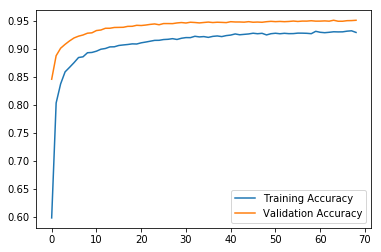

In [26]:
plt.plot(h.history['acc'], label='Training Accuracy')
plt.plot(h.history['val_acc'], label='Validation Accuracy')
plt.legend()